<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/Boston_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 3us/step


In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
train_targets[0]

15.2

Now our data is ready to be fed into a neural network.

In [5]:
!rm -f vaes_net.py
!wget "https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Notebooks/vaes_net.py"

--2020-03-20 15:20:07--  https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Notebooks/vaes_net.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10514 (10K) [text/plain]
Saving to: ‘vaes_net.py’

vaes_net.py         100%[===================>]  10.27K  --.-KB/s    in 0s      

2020-03-20 15:20:07 (120 MB/s) - ‘vaes_net.py’ saved [10514/10514]



In [0]:
labels = ['per capita crime rate by town', 
          'proportion of residential land zoned for lots over 25,000 sq.ft.',
          'proportion of non-retail business acres per town',
          'Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)',
          'nitric oxides concentration (parts per 10 million)',
          'average number of rooms per dwelling',
          'proportion of owner-occupied units built prior to 1940',
          'weighted distances to five Boston employment centres',
          'index of accessibility to radial highways',
          'full-value property-tax rate per $10,000',
          'pupil-teacher ratio by town',
          '1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town',
          '% lower status of the population',
          'Median value of owner-occupied homes in $1000\'s']

In [0]:
import numpy as np

In [8]:
train_data.shape

(404, 13)

In [9]:
train_targets.shape

(404,)

In [0]:
train_data = np.concatenate([train_data, train_targets.reshape((len(train_targets),1))], axis = 1)

In [11]:
train_data.shape

(404, 14)

In [0]:
test_data = np.concatenate([test_data, test_targets.reshape((len(test_targets),1))], axis = 1)

In [13]:
test_data.shape

(102, 14)

In [14]:
data = np.concatenate([train_data,test_data],axis=0)
data.shape

(506, 14)

In [15]:
import pandas as pd

data = pd.DataFrame(data, columns = labels)
data

,per capita crime rate by town,"proportion of residential land zoned for lots over 25,000 sq.ft.",proportion of non-retail business acres per town,Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),nitric oxides concentration (parts per 10 million),average number of rooms per dwelling,proportion of owner-occupied units built prior to 1940,weighted distances to five Boston employment centres,index of accessibility to radial highways,"full-value property-tax rate per $10,000",pupil-teacher ratio by town,1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,% lower status of the population,Median value of owner-occupied homes in $1000's
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9
502,0.07896,0.0,12.83,0.0,0.437,6.273,6.0,4.2515,5.0,398.0,18.7,394.92,6.78,24.1
503,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
504,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71,26.7


In [16]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=100, random_state=2)
qt_trans.fit(data[:1000])
qt = pd.DataFrame(qt_trans.transform(data))
qt.columns = labels

qt

,per capita crime rate by town,"proportion of residential land zoned for lots over 25,000 sq.ft.",proportion of non-retail business acres per town,Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),nitric oxides concentration (parts per 10 million),average number of rooms per dwelling,proportion of owner-occupied units built prior to 1940,weighted distances to five Boston employment centres,index of accessibility to radial highways,"full-value property-tax rate per $10,000",pupil-teacher ratio by town,1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,% lower status of the population,Median value of owner-occupied homes in $1000's
0,0.672697,0.000000,0.449495,0.0,0.515152,0.448171,0.697044,0.621089,0.272727,0.414141,0.939394,1.000000,0.827862,0.195463
1,0.036570,0.974747,0.041375,0.0,0.081374,0.951558,0.036750,0.851160,0.060606,0.525253,0.065657,0.697053,0.025237,0.946027
2,0.788430,0.000000,0.757576,0.0,0.757576,0.026673,1.000000,0.019254,1.000000,0.863636,0.752525,0.250689,0.032351,1.000000
3,0.103654,0.000000,0.257576,0.0,0.434343,0.376083,0.173677,0.826611,0.489899,0.075758,0.752525,1.000000,0.318333,0.494949
4,0.751397,0.000000,0.757576,0.0,0.893939,0.600322,0.636364,0.388883,1.000000,0.863636,0.752525,0.497545,0.660653,0.279461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.745066,0.000000,0.757576,1.0,0.919192,1.000000,0.554187,0.184934,1.000000,0.863636,0.752525,0.174718,0.141414,0.545455
502,0.241375,0.000000,0.595960,0.0,0.156566,0.546738,0.008417,0.658274,0.489899,0.590909,0.474747,0.665699,0.236525,0.696970
503,0.700953,0.000000,0.919192,1.0,0.686869,0.961454,0.880556,0.231891,0.489899,0.641414,0.065657,0.433674,0.001660,1.000000
504,0.550970,0.000000,0.323232,1.0,0.404040,0.855858,0.638413,0.452036,0.717172,0.414141,0.267677,0.505036,0.416125,0.772716


In [0]:
x_train = qt[:404]
x_test = qt[404:]

n_features = qt.shape[1]

In [0]:
train_examples = x_train.shape[0]
flag_0 = np.zeros((train_examples,1),dtype=x_train.values.dtype)
x_train = np.concatenate((x_train.values,flag_0),axis=-1)
test_examples = x_test.shape[0]
flag_1 = np.ones((test_examples,1),dtype=x_test.values.dtype)
x_test = np.concatenate((x_test.values,flag_1),axis=-1)

In [0]:
import vaes_net as vnn
import importlib

In [39]:
from tensorflow import set_random_seed
from numpy.random import seed

importlib.reload(vnn)
seed(42)
set_random_seed(42)

vae = vnn.make_vae(full_data=qt.iloc[:,:n_features],  
    img_shape = (n_features+1, ),
    latent_dim = 1, 
    dense_width = 1024,
    l2_penalty=0.0,
    l1_penalty=0.0,
    encoder_dropout_rate=0,
    decoder_dropout_rate=0,
    input_aug = 0,
    hidden_n = 2,
    optimizer = keras.optimizers.Adam(lr=0.001),
    plot_every_n = 50,
    plot_types_args = {'n_type': 60, 'each_hight' : 20, 
                                  'approx_width': 400, 
                                  'frac_width': 0.55, 
                                  'n_activity':  n_features,  
                                  'lowest_percentile': 1, 
                                  'highest_percentile' : 99, 
                                  'figsize': (10, 6),
                                  'cmap': 'viridis', 
                                  'n_xlabels':13, 
                                  'spacing': -0.001, 
                                  'hist_size': 0.4, 
                                  'scaler': True})  


(?, 1)


In [0]:
epochs = 500
batch_size = 64

Train on 404 samples, validate on 102 samples
Epoch 1/500
 64/404 [===>..........................] - ETA: 3s - loss: 0.3195

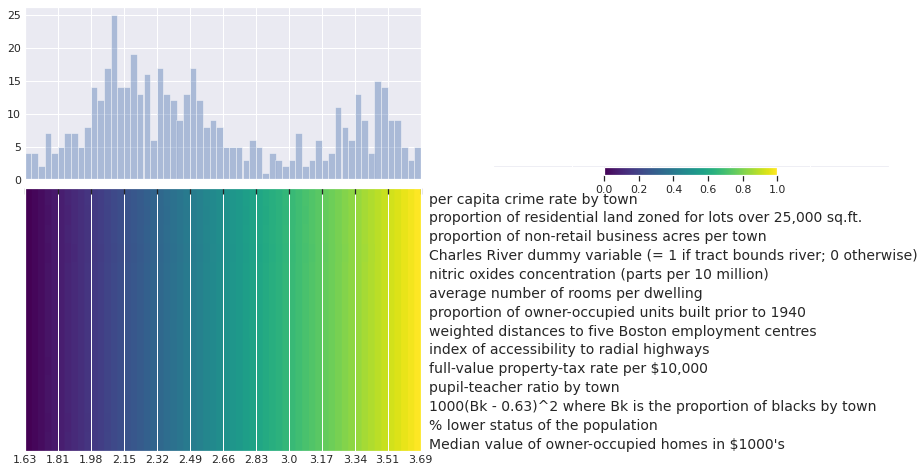

404/404 [==============================] - 2s 5ms/sample - loss: 0.1837 - val_loss: 0.0887
Epoch 2/500
404/404 [==============================] - 0s 102us/sample - loss: 0.0912 - val_loss: 0.0822
Epoch 3/500
404/404 [==============================] - 0s 83us/sample - loss: 0.0874 - val_loss: 0.0831
Epoch 4/500
404/404 [==============================] - 0s 85us/sample - loss: 0.0845 - val_loss: 0.0776
Epoch 5/500
404/404 [==============================] - 0s 87us/sample - loss: 0.0772 - val_loss: 0.0728
Epoch 6/500
404/404 [==============================] - 0s 87us/sample - loss: 0.0660 - val_loss: 0.0548
Epoch 7/500
404/404 [==============================] - 0s 83us/sample - loss: 0.0519 - val_loss: 0.0547
Epoch 8/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0499 - val_loss: 0.0510
Epoch 9/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0469 - val_loss: 0.0465
Epoch 10/500
404/404 [==============================] - 0s 83us/sample - los

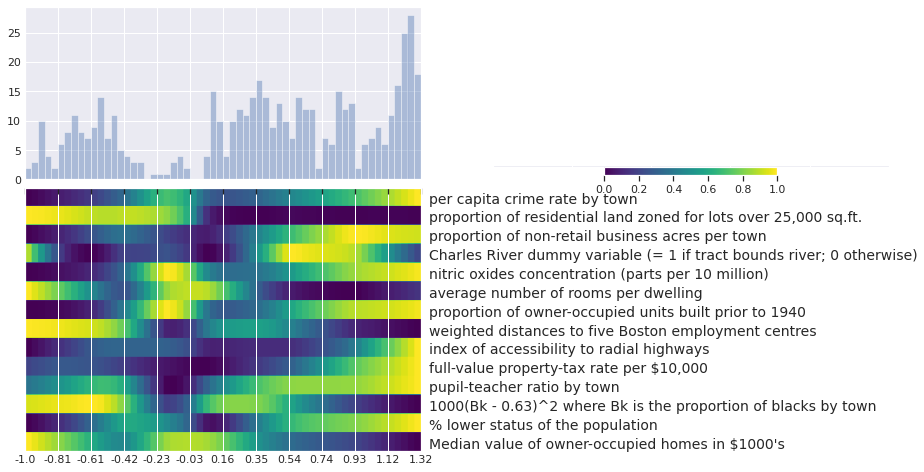

404/404 [==============================] - 1s 3ms/sample - loss: 0.0362 - val_loss: 0.0386
Epoch 52/500
404/404 [==============================] - 0s 106us/sample - loss: 0.0360 - val_loss: 0.0376
Epoch 53/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0357 - val_loss: 0.0373
Epoch 54/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0355 - val_loss: 0.0380
Epoch 55/500
404/404 [==============================] - 0s 86us/sample - loss: 0.0356 - val_loss: 0.0373
Epoch 56/500
404/404 [==============================] - 0s 84us/sample - loss: 0.0350 - val_loss: 0.0370
Epoch 57/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0346 - val_loss: 0.0365
Epoch 58/500
404/404 [==============================] - 0s 80us/sample - loss: 0.0344 - val_loss: 0.0372
Epoch 59/500
404/404 [==============================] - 0s 86us/sample - loss: 0.0352 - val_loss: 0.0365
Epoch 60/500
404/404 [==============================] - 0s 86us/samp

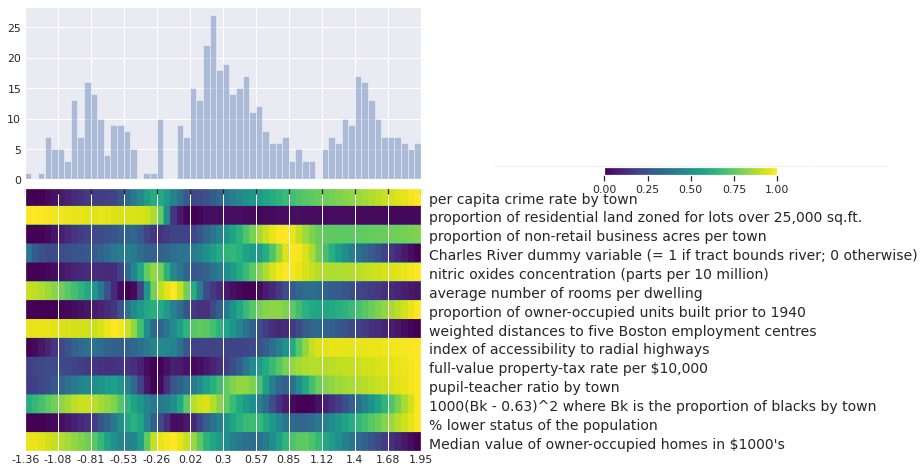

404/404 [==============================] - 1s 3ms/sample - loss: 0.0311 - val_loss: 0.0332
Epoch 102/500
404/404 [==============================] - 0s 97us/sample - loss: 0.0318 - val_loss: 0.0341
Epoch 103/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0336 - val_loss: 0.0378
Epoch 104/500
404/404 [==============================] - 0s 85us/sample - loss: 0.0347 - val_loss: 0.0332
Epoch 105/500
404/404 [==============================] - 0s 83us/sample - loss: 0.0326 - val_loss: 0.0324
Epoch 106/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0310 - val_loss: 0.0314
Epoch 107/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0302 - val_loss: 0.0313
Epoch 108/500
404/404 [==============================] - 0s 87us/sample - loss: 0.0299 - val_loss: 0.0309
Epoch 109/500
404/404 [==============================] - 0s 87us/sample - loss: 0.0294 - val_loss: 0.0308
Epoch 110/500
404/404 [==============================] - 0s 8

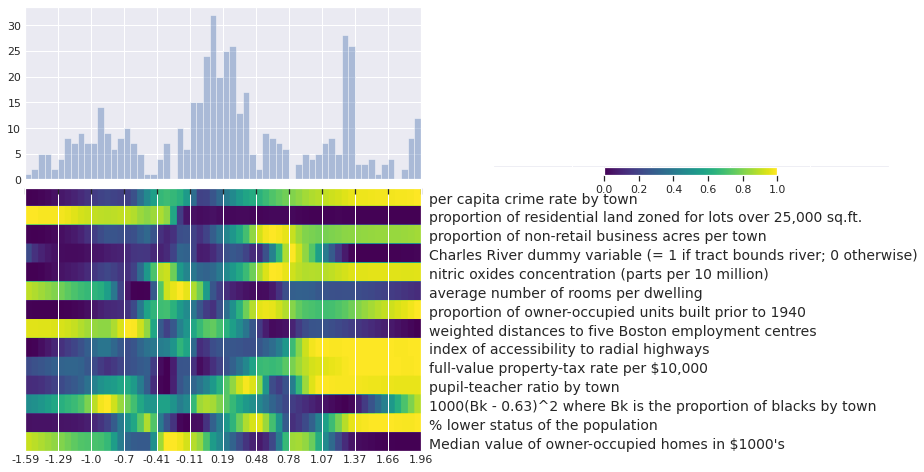

404/404 [==============================] - 1s 3ms/sample - loss: 0.0274 - val_loss: 0.0307
Epoch 152/500
404/404 [==============================] - 0s 97us/sample - loss: 0.0275 - val_loss: 0.0303
Epoch 153/500
404/404 [==============================] - 0s 85us/sample - loss: 0.0278 - val_loss: 0.0292
Epoch 154/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0265 - val_loss: 0.0287
Epoch 155/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0258 - val_loss: 0.0284
Epoch 156/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0264 - val_loss: 0.0312
Epoch 157/500
404/404 [==============================] - 0s 84us/sample - loss: 0.0274 - val_loss: 0.0281
Epoch 158/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0268 - val_loss: 0.0292
Epoch 159/500
404/404 [==============================] - 0s 84us/sample - loss: 0.0272 - val_loss: 0.0300
Epoch 160/500
404/404 [==============================] - 0s 8

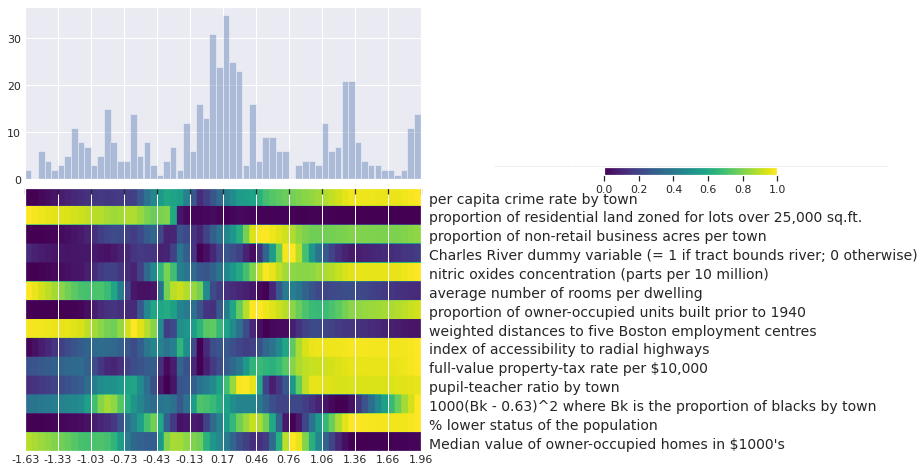

404/404 [==============================] - 1s 3ms/sample - loss: 0.0243 - val_loss: 0.0277
Epoch 202/500
404/404 [==============================] - 0s 107us/sample - loss: 0.0243 - val_loss: 0.0281
Epoch 203/500
404/404 [==============================] - 0s 88us/sample - loss: 0.0245 - val_loss: 0.0277
Epoch 204/500
404/404 [==============================] - 0s 83us/sample - loss: 0.0247 - val_loss: 0.0281
Epoch 205/500
404/404 [==============================] - 0s 84us/sample - loss: 0.0246 - val_loss: 0.0278
Epoch 206/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0245 - val_loss: 0.0273
Epoch 207/500
404/404 [==============================] - 0s 83us/sample - loss: 0.0243 - val_loss: 0.0275
Epoch 208/500
404/404 [==============================] - 0s 83us/sample - loss: 0.0243 - val_loss: 0.0277
Epoch 209/500
404/404 [==============================] - 0s 80us/sample - loss: 0.0244 - val_loss: 0.0274
Epoch 210/500
404/404 [==============================] - 0s 

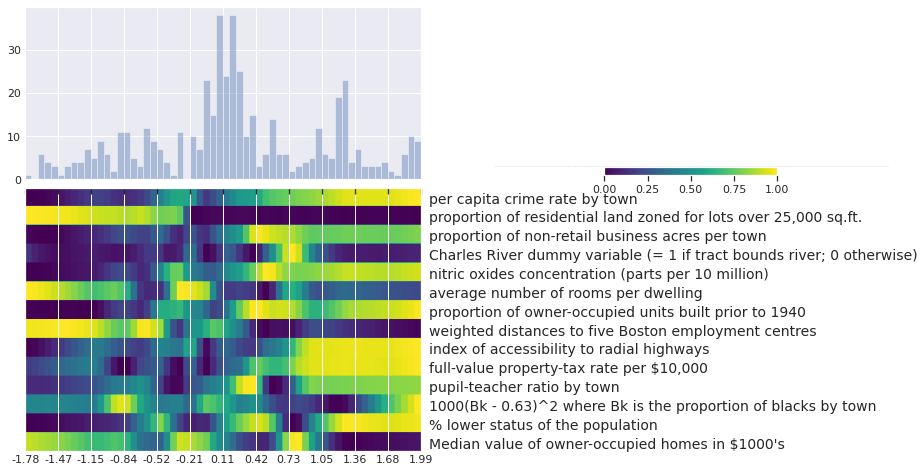

404/404 [==============================] - 1s 3ms/sample - loss: 0.0244 - val_loss: 0.0284
Epoch 252/500
404/404 [==============================] - 0s 109us/sample - loss: 0.0248 - val_loss: 0.0285
Epoch 253/500
404/404 [==============================] - 0s 86us/sample - loss: 0.0242 - val_loss: 0.0263
Epoch 254/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0237 - val_loss: 0.0283
Epoch 255/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0240 - val_loss: 0.0287
Epoch 256/500
404/404 [==============================] - 0s 85us/sample - loss: 0.0242 - val_loss: 0.0273
Epoch 257/500
404/404 [==============================] - 0s 83us/sample - loss: 0.0236 - val_loss: 0.0264
Epoch 258/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0231 - val_loss: 0.0269
Epoch 259/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0232 - val_loss: 0.0271
Epoch 260/500
404/404 [==============================] - 0s 

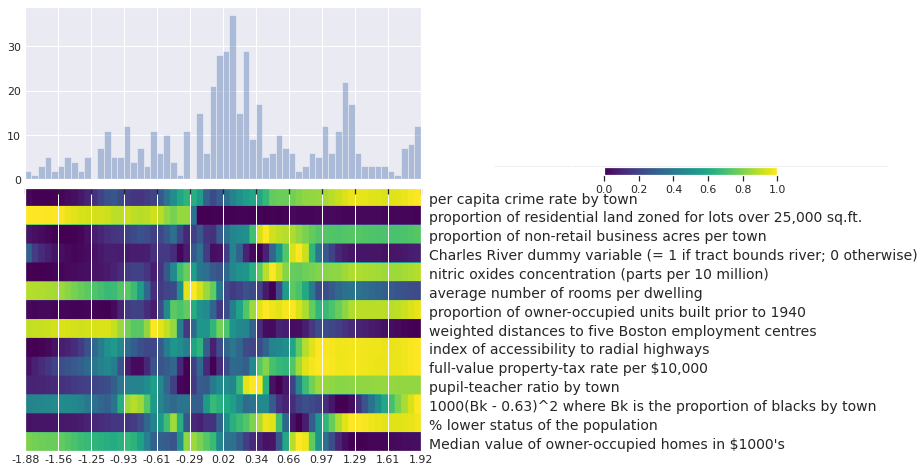

404/404 [==============================] - 1s 3ms/sample - loss: 0.0228 - val_loss: 0.0259
Epoch 302/500
404/404 [==============================] - 0s 92us/sample - loss: 0.0224 - val_loss: 0.0263
Epoch 303/500
404/404 [==============================] - 0s 85us/sample - loss: 0.0222 - val_loss: 0.0258
Epoch 304/500
404/404 [==============================] - 0s 86us/sample - loss: 0.0225 - val_loss: 0.0260
Epoch 305/500
404/404 [==============================] - 0s 94us/sample - loss: 0.0225 - val_loss: 0.0266
Epoch 306/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0224 - val_loss: 0.0269
Epoch 307/500
404/404 [==============================] - 0s 86us/sample - loss: 0.0225 - val_loss: 0.0270
Epoch 308/500
404/404 [==============================] - 0s 88us/sample - loss: 0.0228 - val_loss: 0.0266
Epoch 309/500
404/404 [==============================] - 0s 84us/sample - loss: 0.0224 - val_loss: 0.0271
Epoch 310/500
404/404 [==============================] - 0s 8

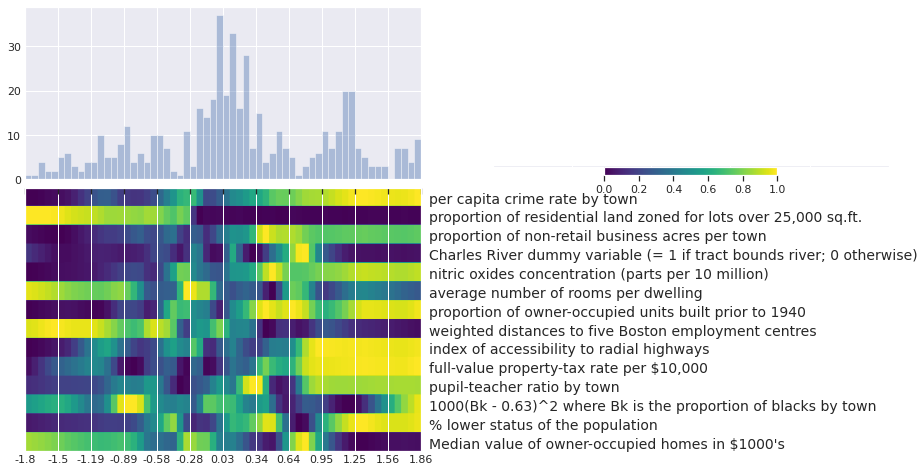

404/404 [==============================] - 1s 3ms/sample - loss: 0.0220 - val_loss: 0.0268
Epoch 352/500
404/404 [==============================] - 0s 105us/sample - loss: 0.0218 - val_loss: 0.0265
Epoch 353/500
404/404 [==============================] - 0s 85us/sample - loss: 0.0220 - val_loss: 0.0256
Epoch 354/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0217 - val_loss: 0.0270
Epoch 355/500
404/404 [==============================] - 0s 92us/sample - loss: 0.0213 - val_loss: 0.0260
Epoch 356/500
404/404 [==============================] - 0s 83us/sample - loss: 0.0216 - val_loss: 0.0264
Epoch 357/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0214 - val_loss: 0.0261
Epoch 358/500
404/404 [==============================] - 0s 77us/sample - loss: 0.0212 - val_loss: 0.0268
Epoch 359/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0214 - val_loss: 0.0259
Epoch 360/500
404/404 [==============================] - 0s 

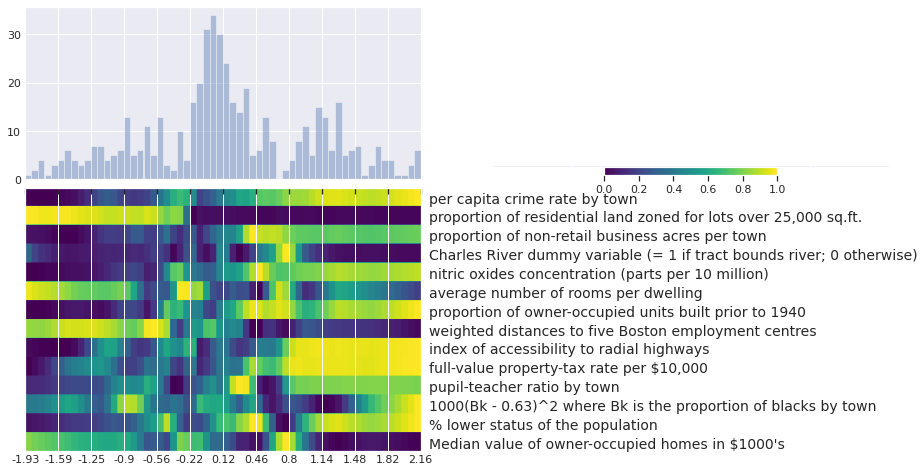

404/404 [==============================] - 1s 3ms/sample - loss: 0.0211 - val_loss: 0.0266
Epoch 402/500
404/404 [==============================] - 0s 110us/sample - loss: 0.0212 - val_loss: 0.0269
Epoch 403/500
404/404 [==============================] - 0s 90us/sample - loss: 0.0209 - val_loss: 0.0259
Epoch 404/500
404/404 [==============================] - 0s 85us/sample - loss: 0.0209 - val_loss: 0.0259
Epoch 405/500
 64/404 [===>..........................] - ETA: 0s - loss: 0.0188
Epoch 00405: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
404/404 [==============================] - 0s 84us/sample - loss: 0.0207 - val_loss: 0.0264
Epoch 406/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0206 - val_loss: 0.0273
Epoch 407/500
404/404 [==============================] - 0s 86us/sample - loss: 0.0212 - val_loss: 0.0259
Epoch 408/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0209 - val_loss: 0.0258
Epoch 409/500
404/40

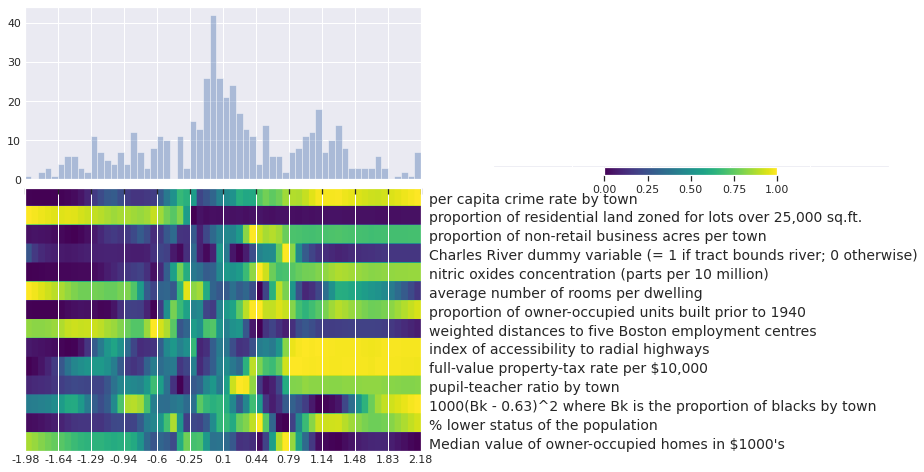

404/404 [==============================] - 1s 3ms/sample - loss: 0.0201 - val_loss: 0.0267
Epoch 452/500
404/404 [==============================] - 0s 99us/sample - loss: 0.0199 - val_loss: 0.0264
Epoch 453/500
404/404 [==============================] - 0s 85us/sample - loss: 0.0199 - val_loss: 0.0264
Epoch 454/500
404/404 [==============================] - 0s 81us/sample - loss: 0.0197 - val_loss: 0.0262
Epoch 455/500
404/404 [==============================] - 0s 80us/sample - loss: 0.0201 - val_loss: 0.0263
Epoch 456/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0197 - val_loss: 0.0265
Epoch 457/500
404/404 [==============================] - 0s 79us/sample - loss: 0.0199 - val_loss: 0.0258
Epoch 458/500
404/404 [==============================] - 0s 87us/sample - loss: 0.0198 - val_loss: 0.0261
Epoch 459/500
404/404 [==============================] - 0s 82us/sample - loss: 0.0198 - val_loss: 0.0261
Epoch 460/500
404/404 [==============================] - 0s 8

In [41]:
fitted = vae.fit(
    x=x_train, 
    y=None,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, None),
    callbacks = vae.callback_list
    )

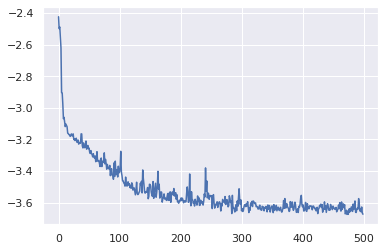

In [42]:
import matplotlib.pyplot as plt

plt.plot(np.log(fitted.history['val_loss']))

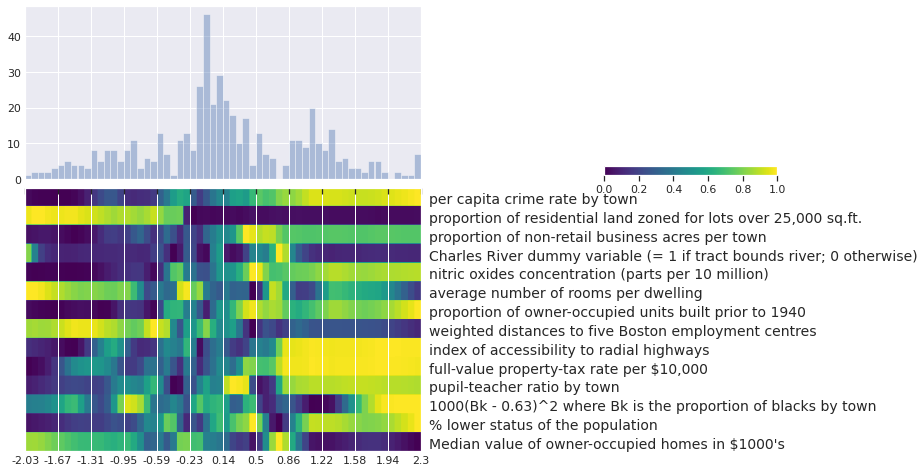

In [43]:
vnn.plot_types(encoder=vae.encoder,decoder=vae.decoder,data=qt, 
               **{'n_type': 60, 'each_hight' : 20, 
                                  'approx_width': 400, 
                                  'frac_width': 0.55, 
                                  'n_activity':  n_features,  
                                  'lowest_percentile': 1, 
                                  'highest_percentile' : 99, 
                                  'figsize': (10, 6),
                                  'cmap': 'viridis', 
                                  'n_xlabels':13, 
                                  'spacing': 0.000, 
                                  'hist_size': 0.4, 
                                  'scaler': True});

In [44]:
flag_1 = np.ones((qt.shape[0],1),dtype=qt.values.dtype)
data = np.concatenate((qt.values,flag_1),axis=-1)
encoded_data=pd.DataFrame(vae.encoder.predict(data))
encoded_data

,0
0,0.203235
1,-1.571489
2,0.873477
3,-0.050109
4,1.508108
...,...
501,0.858634
502,-0.049326
503,0.700649
504,-0.217780
